# Projeto Final de Ciência dos Dados. ( PkmnID)

## Algoritmo de predição da categoria de Pokémons por meio de suas imagens.
### O algoritmo realiza a extração e a clusterização de features de imagens por meio do método \"Bag of Visual Words\" (BOVW),classifica-as utilizando o método de machine learning \"Random Forest\" e prevê a categoria de Pokémons por meio de novas imagens.

In [30]:
!pip install opencv-contrib-python
import cv2
import os
import os.path
import numpy as np
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from pprint import pprint

np.random.seed(0)

## 1- Extração de features de imagens: Bag of Visual Words
### Uma vez que o dataset se trata de um conjunto de imagens de diferentes Pokémons, é necessário inicialmente extrair features dessas imagens, através do método "Bag of Visual Words".
### Com as imagens transformadas em features clusterizadas, elas são separadas em categorias de treino e teste, que serão utilizadas posteriormente pelo algoritmo de machine learning.
### O código abaixo realiza essas duas etapas:
#### Obs: Código produzido com a assistência do Prof. Fábio Ayres

In [31]:
TRAIN_DIR = 'Assets//Data_Train'
TEST_DIR = 'Assets//Data_Test'

NUM_CLUSTERS = 50

TRAIN_IMG = []
TEST_IMG = []
TRAIN_LABEL = []
TEST_LABEL = []

for train, test in zip(os.listdir(TRAIN_DIR), os.listdir(TEST_DIR)): #Tecnicamente são iguais, mas não custa garantir.
    for img_train, img_test in zip(os.listdir(os.path.join(TRAIN_DIR,train)), os.listdir(os.path.join(TEST_DIR,test))):
        TRAIN_IMG.append(os.path.join(TRAIN_DIR,train,img_train))
        TEST_IMG.append(os.path.join(TEST_DIR,test,img_test))
        TRAIN_LABEL.append(train)
        TEST_LABEL.append(test)


def cria_vocabulario(imagens, num_clusters):
    km = cv2.BOWKMeansTrainer(num_clusters)
    akaze = cv2.KAZE_create()
    for p in imagens:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        mask = np.ones(img.shape)
        kp, desc = akaze.detectAndCompute(img, mask)
        km.add(desc)
    return km.cluster()

def representa(vocab, img):
    kaze = cv2.KAZE_create()
    kp = kaze.detect(img)
    bowdesc = cv2.BOWImgDescriptorExtractor(kaze, cv2.FlannBasedMatcher())
    bowdesc.setVocabulary(vocab)
    return bowdesc.compute(img, kp)

def transforma_imagens(imagens, vocab):
    X = []
    for p in imagens:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        X.append(representa(vocab, img).flatten())
    return np.array(X)

def show_example(path = "Testes/Testes/Bellsprout.png", Plot = True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, dsize=(120, 120))
    if Plot:
        plt.imshow(img_resized, cmap='gray', vmin=0, vmax=255)
    return representa(vocab, img_resized)


vocab = cria_vocabulario(TRAIN_IMG, NUM_CLUSTERS)
X_train = transforma_imagens(TRAIN_IMG, vocab)
X_test = transforma_imagens(TEST_IMG, vocab)
y_train = TRAIN_LABEL
y_test = TEST_LABEL

## 2 - Análise Exploratória:
### Para realizar a análise exploratória seguiremos alguns passos:
### 2.1 - Extrair histograma:
### O código abaixo cria o histograma de frequências relativas das features de todas as imagens do dataset escolhido."

In [12]:
origin_dir = 'Assets//Data_Filtered_Resized'
Hist_Dict = {}
for pkmn in os.listdir(origin_dir):
    Hist_Dict[pkmn] = []
    current_dir = os.path.join(origin_dir,pkmn)
    for k, img in enumerate(os.listdir(current_dir)):
        Hist_Dict[pkmn].append(show_example(os.path.join(current_dir,img), Plot = False))
# print(Hist_Dict['Alakazam'])

## 2.2 - Criar um dataframe para trabalhar melhor com o dataset:

In [13]:
lista = []
lista_nomes = os.listdir('Assets/Data_Filtered_Resized')
for k in Hist_Dict:
    x = pd.Series(Hist_Dict[k]).mean()
    x = pd.Series(x[0])
    lista.append(x)
df_medias = pd.DataFrame(lista, index = lista_nomes)

## Tabela das frequências relativas médias de cada feature por pokémon:

In [14]:
df_medias.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Aerodactyl,0.040814,0.012634,0.026345,0.004548,0.024529,0.013538,0.003587,0.023434,0.017972,0.013794,...,0.008755,0.006726,0.026707,0.003096,0.059906,0.037618,0.005562,0.028472,0.007510,0.003137
Alakazam,0.064608,0.033090,0.014522,0.004900,0.023877,0.019926,0.004525,0.030281,0.029310,0.012223,...,0.006362,0.005910,0.035591,0.004223,0.025083,0.025470,0.008104,0.024919,0.005989,0.005782
Arbok,0.059906,0.009567,0.058574,0.027694,0.015935,0.013322,0.013044,0.012965,0.013964,0.017960,...,0.009187,0.018073,0.012466,0.007617,0.016770,0.010640,0.010261,0.010404,0.024618,0.010615
Arcanine,0.041483,0.029640,0.032206,0.020275,0.020844,0.018229,0.004691,0.033178,0.042017,0.016361,...,0.003778,0.008922,0.030083,0.005562,0.008152,0.020654,0.003874,0.011626,0.008247,0.009594
Beedrill,0.040260,0.028357,0.015417,0.013190,0.025890,0.020019,0.004118,0.043090,0.027669,0.018481,...,0.005180,0.004356,0.039317,0.002232,0.028128,0.016261,0.007620,0.018644,0.005626,0.004729


## 2.3 - Calculando os valores médios dos dados:
### Nesta etapa foi calculado os valores médios dos dados, e em sequência foram aproximados do ponto (0,0), origem do sistema.

In [15]:
df_medias = df_medias - (1/40) 

In [16]:
df_medias.sum(axis=1)

Aerodactyl   -0.25
Alakazam     -0.25
Arbok        -0.25
Arcanine     -0.25
Beedrill     -0.25
Bellsprout   -0.25
Bulbasaur    -0.25
Charmander   -0.25
Jigglypuff   -0.25
Meowth       -0.25
Pidgey       -0.25
Squirtle     -0.25
Voltorb      -0.25
dtype: float32

In [17]:
normas = (df_medias*df_medias).sum(axis=1)
for m in normas.index:
    df_medias.loc[m] = df_medias.loc[m]/np.sqrt(normas[m])

## 2.4 - Comparação entre os Pokémons:
### Com base nos valores calculados anteriormente, foi criada a tabela seguinte, que mostra o quanto os Pokémons são semelhantes entre si, sendo 1 a semelhança máxima, e -1 o oposto.

In [18]:
df_compara = df_medias.dot(df_medias.transpose())
df_compara

,Aerodactyl,Alakazam,Arbok,Arcanine,Beedrill,Bellsprout,Bulbasaur,Charmander,Jigglypuff,Meowth,Pidgey,Squirtle,Voltorb
Aerodactyl,1.000000,0.720618,0.282252,0.435118,0.689246,0.438970,0.160929,0.572704,0.188135,0.516534,0.566425,0.374125,0.394842
Alakazam,0.720618,1.000000,0.299259,0.761672,0.853467,0.677626,0.235033,0.521207,0.485344,0.838307,0.624879,0.579078,0.083050
Arbok,0.282252,0.299259,1.000000,0.475168,0.261453,0.212385,0.669289,0.533443,0.229574,0.239759,0.369069,0.607399,0.696724
Arcanine,0.435118,0.761672,0.475168,1.000000,0.840589,0.810544,0.576935,0.719155,0.734874,0.851162,0.838832,0.903170,0.217568
Beedrill,0.689246,0.853467,0.261453,0.840589,1.000000,0.773353,0.301859,0.629603,0.579994,0.850784,0.793401,0.678083,0.184437
Bellsprout,0.438970,0.677626,0.212385,0.810544,0.773353,1.000000,0.239028,0.603749,0.748429,0.824173,0.782793,0.729976,0.109082
Bulbasaur,0.160929,0.235033,0.669289,0.576935,0.301859,0.239028,1.000000,0.662592,0.491129,0.373103,0.519342,0.703155,0.529741
Charmander,0.572704,0.521207,0.533443,0.719155,0.629603,0.603749,0.662592,1.000000,0.606549,0.639829,0.886392,0.867053,0.571029
Jigglypuff,0.188135,0.485344,0.229574,0.734874,0.579994,0.748429,0.491129,0.606549,1.000000,0.753170,0.664669,0.699824,0.239034
Meowth,0.516534,0.838307,0.239759,0.851162,0.850784,0.824173,0.373103,0.639829,0.753170,1.000000,0.775107,0.727057,0.103041


### Podemos observar que alguns Pokémons possuem muitas semelhanças pois apresentam as mesmas features em abundância (na média)."

In [19]:
monstros = []
for feat in range(NUM_CLUSTERS):
    monstros.append(sorted(df_medias.nlargest(n=5, columns=[feat]).index) + [feat])
x = sorted(monstros)
pprint(x)

[['Aerodactyl', 'Alakazam', 'Arbok', 'Beedrill', 'Voltorb', 44],
 ['Aerodactyl', 'Alakazam', 'Arcanine', 'Beedrill', 'Meowth', 4],
 ['Aerodactyl', 'Alakazam', 'Arcanine', 'Beedrill', 'Meowth', 33],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Bulbasaur', 'Jigglypuff', 23],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Charmander', 'Meowth', 21],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Charmander', 'Voltorb', 25],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Charmander', 'Voltorb', 27],
 ['Aerodactyl', 'Alakazam', 'Bulbasaur', 'Charmander', 'Pidgey', 47],
 ['Aerodactyl', 'Arbok', 'Bellsprout', 'Jigglypuff', 'Voltorb', 19],
 ['Aerodactyl', 'Arbok', 'Bulbasaur', 'Jigglypuff', 'Voltorb', 17],
 ['Aerodactyl', 'Arbok', 'Bulbasaur', 'Jigglypuff', 'Voltorb', 36],
 ['Aerodactyl', 'Beedrill', 'Bellsprout', 'Charmander', 'Pidgey', 24],
 ['Aerodactyl', 'Beedrill', 'Charmander', 'Meowth', 'Pidgey', 31],
 ['Aerodactyl', 'Bulbasaur', 'Charmander', 'Meowth', 'Pidgey', 28],
 ['Aerodactyl', 'Charmander', 'Meowth', 

### A soma das colunas da tabela anterior mostra quais Pokémons são mais difíceis de distinguir.

In [20]:
df_compara.sum(axis = 1).sort_values(ascending = False)

Arcanine      9.164786
Squirtle      9.148969
Pidgey        9.082934
Charmander    8.813304
Meowth        8.492026
Beedrill      8.436270
Bellsprout    7.950106
Alakazam      7.679541
Jigglypuff    7.420726
Bulbasaur     6.462133
Aerodactyl    6.339898
Arbok         5.875774
Voltorb       4.936913
dtype: float32

## 3 - "Machine Learning" e Classificação:
### O método de aprendizado de máquina e classificação utilizado foi o "Random Forest Classifier".

In [21]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators = 100)
clf.fit(X_train, y_train)
scr = clf.score(X_test, y_test)

### Abaixo estão a acurácia do modelo, e a acurácia esperada caso a classificação fosse aleatória.

In [22]:
scr, 1/13

(0.488929889298893, 0.07692307692307693)

## 3.1 - Análise das classificações realizadas pelo modelo:
### A matriz de confusão abaixo mostra em mais detalhes os erros e acertos do classificador. É possível identificar que na maioria das vezes que o modelo falhou, ele identificou erroneamente o Pokémon como sendo uma "Jigglypuff" ou um "Arcanine".

#### Obs: O código abaixo não é de nossa autoria, e sua versão original pode ser encontrada no seguinte endereço: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

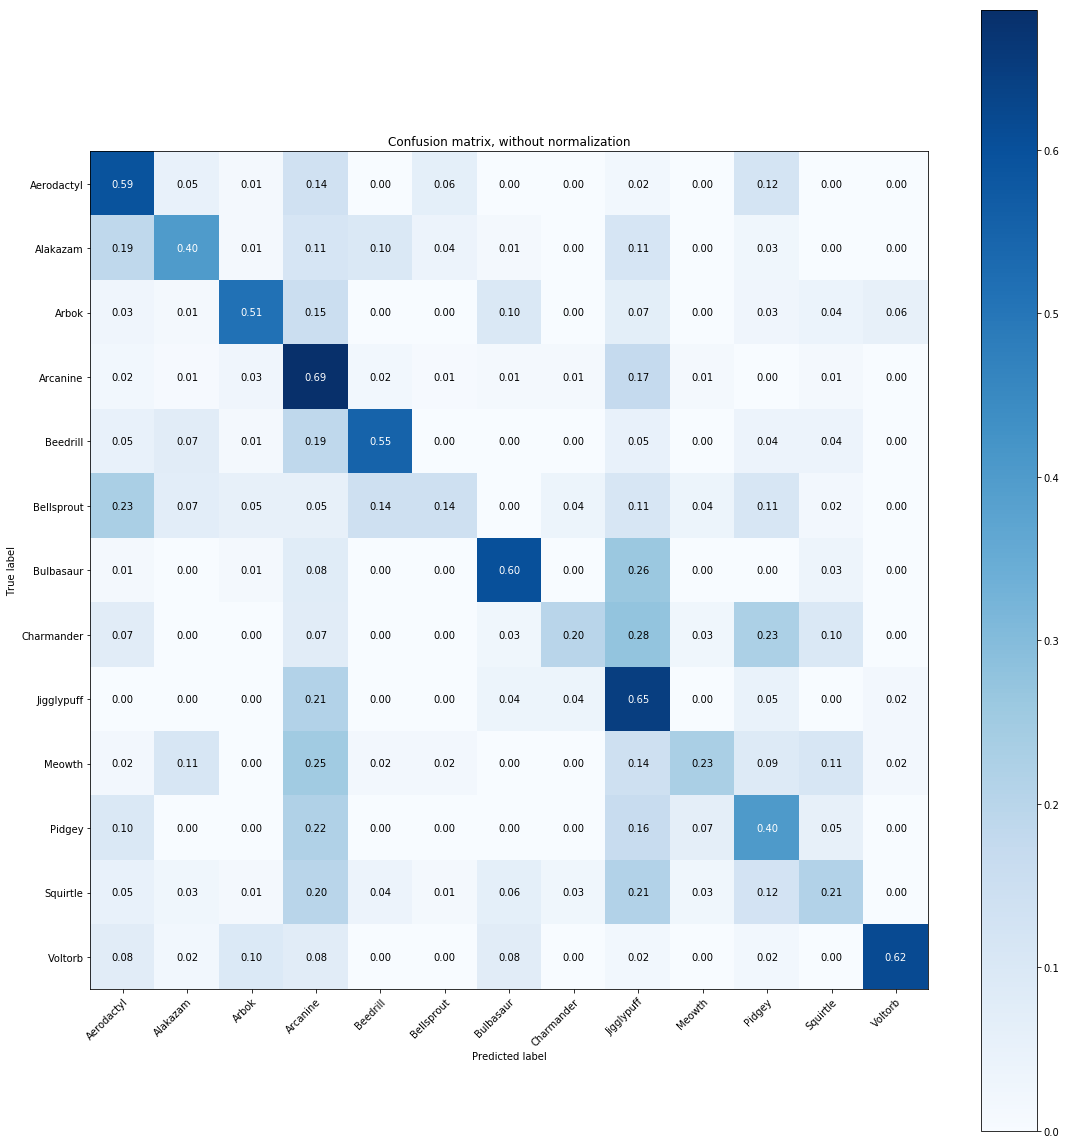

In [29]:
y_pred = clf.predict(X_test)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=clf.classes_,
                      title='Confusion matrix, without normalization')



plt.show()

In [24]:
hits, miss = 0, 0
for img, label in zip(TEST_IMG, TEST_LABEL):
    rep = representa(vocab, cv2.imread(img))
    top3 = pd.Series(clf.predict_proba(rep)[0], index = os.listdir('Assets/Data_Test')).nlargest(3)
    if label in top3.index.tolist():
        hits += 1
    else:
        miss += 1
        
hits, miss, hits/(hits+miss)

(773, 311, 0.7130996309963099)

(array([[0.09, 0.03, 0.02, 0.09, 0.03, 0.09, 0.02, 0.1 , 0.02, 0.  , 0.33,
         0.17, 0.01]]),
 array(['Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Beedrill',
        'Bellsprout', 'Bulbasaur', 'Charmander', 'Jigglypuff', 'Meowth',
        'Pidgey', 'Squirtle', 'Voltorb'], dtype='<U10'))

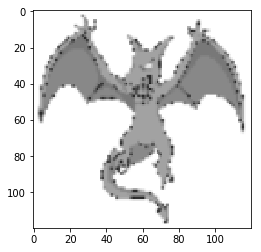

In [25]:
clf.predict_proba(show_example()), clf.classes_

## Bibliografia:
- Modelo Bag of Visual Words, e parte da análise exploratória produzidos por/com assistência de Fábio Ayres.
- Dataset: [Pokémon Gen One](https://www.kaggle.com/thedagger/pokemon-generation-one/data) da plataforma Kaggle.com
